In [1]:
import argparse
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset_builder, load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader
import os
import json
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import random
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import time
import difflib


from finetune import CloneDetector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Functions

In [2]:
def find_threshold(scores, labels, metric='f1'):
    # metric: 'acc' or 'f1'

    for label in labels:
        assert abs(label - 1) < 1e-10 or abs(label) < 1e-10
    assert metric in ['acc', 'f1']

    arr = sorted(list(zip(scores, labels)), key=lambda x: x[0])

    pre = 0.0
    post = sum(labels)

    max_eval, best_threshold = 0.0, arr[0][0]
    for i in range(len(arr) - 1):
        pre += arr[i][1]
        post -= arr[i][1]

        tp = post
        fp = len(arr) - i - post
        fn = pre
        tn = (i-pre)

        acc = (tp + tn) / len(arr)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

        eval = {'acc': acc, 'f1': f1}

        if max_eval < eval[metric]:
            max_eval = acc
            best_threshold = (arr[i][0] + arr[i][1]) / 2
    return best_threshold

def accuracy(scores, labels, threshold):
    return np.mean(((scores > threshold).astype(np.int32) == labels).astype(np.float32)).tolist()


def f1_score(scores, labels, threshold):
    return metrics.f1_score((scores > threshold), labels)

def sumCounter(counter):
    return sum(counter.values())

    
class AugmentedDataset(Dataset):
    def __init__(self, inputs):
        self.data = inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


# Load Model

In [3]:
%%time


model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
batch_size = 8

def tokenize(code):
    return tokenizer(code, return_tensors="pt", truncation=True, padding="longest", max_length=512)

def collate_fn(items):
    x = {}

    code1, code2, labels = [], [], []
    for item in items:
        code1.append(item['code1'])
        code2.append(item['code2'])
        labels.append(item['similar'])

    x['code1'] = tokenize(code1)
    x['code2'] = tokenize(code2)
    x['labels'] = torch.tensor(labels, dtype=torch.float32)

    return x



ckpt_path = '/mnt/ssd/696ds/checkpoints/0327_codebert-base_lr3.0e-07-w5000/step1000000.pt'
# model = CloneDetector(model_name, device)
model = torch.load(ckpt_path).to(device)
model.device = device
model.train(False)

CPU times: user 2.86 s, sys: 1.31 s, total: 4.17 s
Wall time: 4.94 s


CloneDetector(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

# Find threshold using val data from a different fold (fold 5/5)

In [4]:
# %%time
# batch_size = 8
# n_th = 30000

# dataset = load_from_disk("/mnt/ssd/696ds_data/PoolC/original/5-fold-clone-detection-600k-5fold")["val"]
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [5]:
# %%time
# scores_list, labels_list = [], []
# pbar = tqdm(dataloader, total=(n_th+batch_size-1) // batch_size)
# for i, batch in enumerate(pbar):
        
#     if batch_size * i >= n_th:
#         break
    
#     labels = batch['labels']
    
#     scores = model(batch).to('cpu')
    
#     scores, labels = scores.tolist(), labels.tolist()
    
#     scores_list += scores if type(scores) == list else [scores]
#     labels_list += labels if type(labels) == list else [labels]
    
# scores, labels = np.array(scores_list), np.array(labels_list)
# threshold = find_threshold(scores, labels)
# acc, f1 = accuracy(scores, labels, threshold), f1_score(scores, labels, threshold)
# print(threshold)

In [6]:
threshold = 0.7560033202171326

# Read Augmented Dataset

In [7]:
%%time
save_dir = "/mnt/ssd/696ds_data/PoolC/2-fold-clone-detection-600k-5fold/train/041223/"
print(os.listdir(save_dir))
save_path = os.path.join(save_dir, "augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_group.json")

# p2index = {"0.5": 0}

with open(save_path, 'r') as f:
    json_data = json.load(f)
    print(type(json_data))
    
data = json_data['data']



['augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_each.json', 'augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_group.json']
<class 'dict'>
CPU times: user 10.8 s, sys: 1.66 s, total: 12.4 s
Wall time: 13.5 s


In [8]:
print(data[0]['augmented'][0].keys())

dict_keys(['code1', 'code1_log', 'code2', 'code2_log'])


In [9]:
print(data[0]['augmented'][0]['code1_log'].keys())

dict_keys(['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports'])


In [10]:
print(data[0]['augmented'][0]['code1'].keys())

dict_keys(['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports'])


# Evaluate on the PoolC dataset

In [11]:
def func(datapoints):
        
    dataset = AugmentedDataset(datapoints)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    scores_list = []
    labels_list = []
    for j, batch in enumerate(dataloader):

        labels = batch['labels']
        scores = model(batch).to('cpu')

        labels, scores = labels.tolist(), scores.tolist()
        labels_list += labels if type(labels) == list else [labels]
        scores_list += scores if type(scores) == list else [scores]


    scores = np.array(scores_list)
    labels = np.array(labels_list)
    return np.array(scores_list), np.array(labels_list)

def original_scores(n):
    dataset1 = []
    for i in range(len(data)):
        if len(dataset1) == n:
            break
            
        dataset1.append(
            {
                'code1': data[i]['original']['code1'],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )

    scores1, labels1 = func(dataset1)
    acc1 = accuracy(scores1, labels1, threshold)
    f1_1 = f1_score(scores1, labels1, threshold)
    
    
    results = {
        'Accuracy': acc1,
        'F1': f1_1,
        'Mean': np.mean(scores1),
        'Standard Deviation': np.std(scores1),
        'Same Prediction': 1.0,
        'Mean Absolute Difference': 0.0,
#         'Standard Deviation of Absolute Difference': 0.0,
#         'Root Mean Squared Difference': 0.0
        
    }
    
    return scores1, results
    

def augmented_scores(p, transformation_type, n, scores1):
    index = p2index[p]
    logs = Counter()
    dataset2 = []
    for i in range(len(data)):
        if len(dataset2) == n:
            break
            
        dataset2.append(
            {
                'code1': data[i]['augmented'][p2index[p]]['code1'][transformation_type],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )
        
        for key, value in data[i]['augmented'][p2index[p]]['code1_log'][transformation_type].items():
            logs[key] += value
            
    scores, labels = func(dataset2)

    acc = accuracy(scores, labels, threshold)
    f1 = f1_score(scores, labels, threshold)
    mean_absolute_difference = np.mean(np.abs(scores1-scores))
    
    results = {
        'Accuracy': acc,
        'F1': f1,
        'Mean': np.mean(scores),
        'Standard Deviation': np.std(scores),
        'Same Prediction': np.mean((scores1 > threshold) == (scores > threshold)),
        'Mean Absolute Difference': mean_absolute_difference,
#         'Standard Deviation of Absolute Difference': np.std(abs(scores1-scores) - mean_absolute_difference),
#         'Root Mean Squared Difference': np.sqrt(np.mean((scores1 - scores) ** 2))
    }
    
    diffs = [i for i, same in enumerate((scores1 > threshold) == (scores > threshold)) if not same]
    
    
#     print('p:', p)
#     for key, value in results.items():
#         print(f"{key:<30}: {value:>3.3f}")
#     print()
    return results, logs, diffs


In [12]:
%%time
n_pc = 10000

scores1, results1 = original_scores(n_pc)


CPU times: user 1min 43s, sys: 4.82 s, total: 1min 48s
Wall time: 2min 1s


In [13]:
print(results1)

{'Accuracy': 0.8482000231742859, 'F1': 0.8629221600144483, 'Mean': 1.5386816241636299, 'Standard Deviation': 1.88646069390785, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}


In [14]:
p2index = {f'0.{i+1}': i for i in range(9)}
p2index['1.0'] = 9
transformation_types = list(data[0]['augmented'][0]['code1_log'].keys())

In [15]:
%%time
targets = sorted(list(p2index.keys()), key=lambda x:float(x))
# targets = ['0.2', '0.5', '0.7', '1.0']
results = defaultdict(dict)
logs = defaultdict(dict)
diffs = defaultdict(dict)
for transformation_type in transformation_types:
    for p in targets:
        results[transformation_type]['0.0'] = results1
        logs[transformation_type]['0.0'] = Counter()
        results[transformation_type][p], logs[transformation_type][p], diffs[transformation_type][p] = \
                    augmented_scores(p, transformation_type, n_pc, scores1)

CPU times: user 2h 21min 25s, sys: 7min 14s, total: 2h 28min 40s
Wall time: 2h 17min 49s


In [16]:

targets = ["0.0"] + targets
x = [float(target) for target in targets]


In [17]:
print(transformation_types)

labels = {
    'add_whitespace,add_new_lines,add_commas': 'add whitespaces, new lines, commas',
    'list_comp_to_for,set_comp_to_for,dict_comp_to_for': 'comprehension to for loop',
    'change_variable_names': 'change local variable names',
    'for_to_while,lambda_to_function,combine_statement': 'for loop to while loop, lambda to function, combine statement',
    'remove_comments': 'remove comments',
    'remove_empty_line,remove_whitespace,remove_commas': 'remove empty lines, whitespaces, commas',
    'remove_unused_imports': 'remove unused imports'
}

['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports']


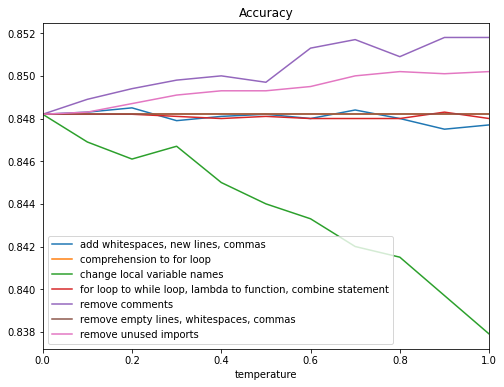

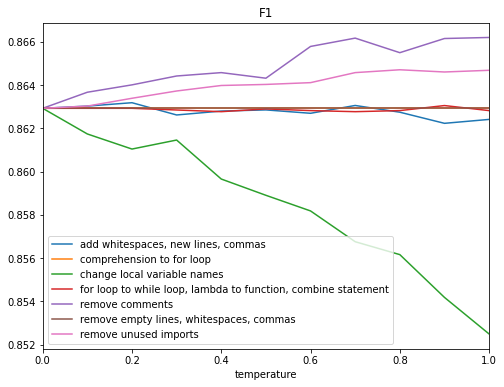

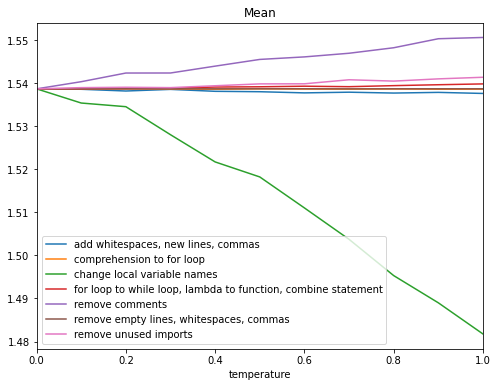

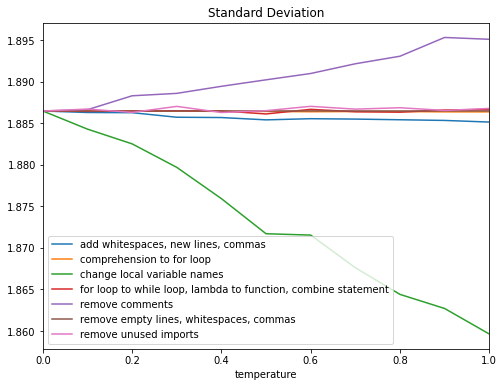

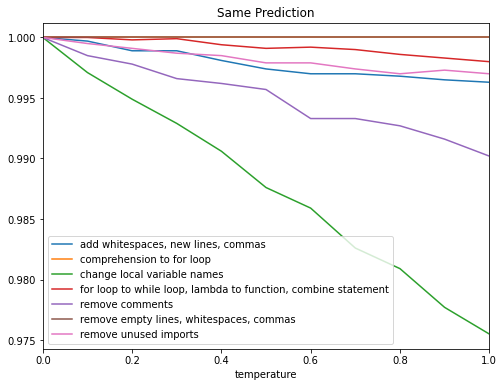

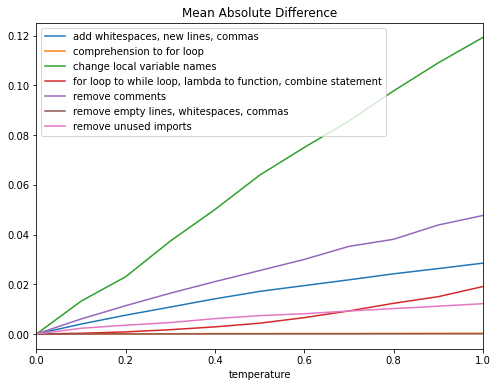

In [18]:
metrics_list = ['Accuracy', 'F1', 'Mean', 'Standard Deviation', 'Same Prediction', 
                'Mean Absolute Difference']
# cm = plt.get_cmap('gist_rainbow')

for metric in metrics_list:
    plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
    for i, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])

    plt.title(metric)
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
    plt.show()

# Number of changes

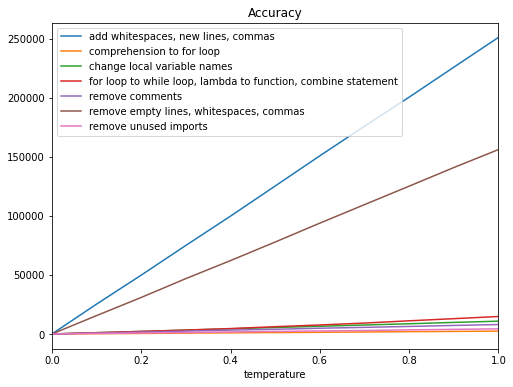

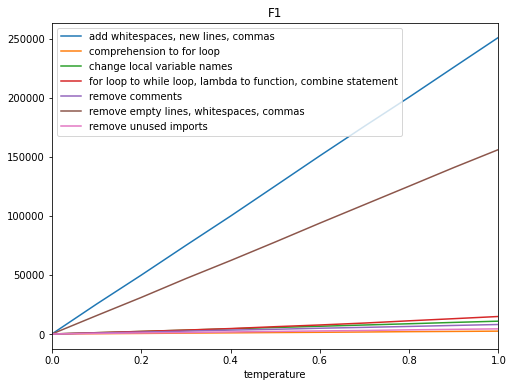

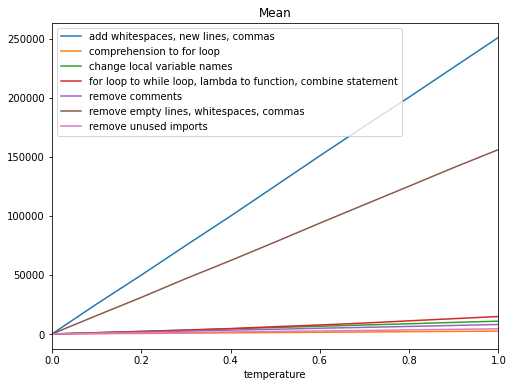

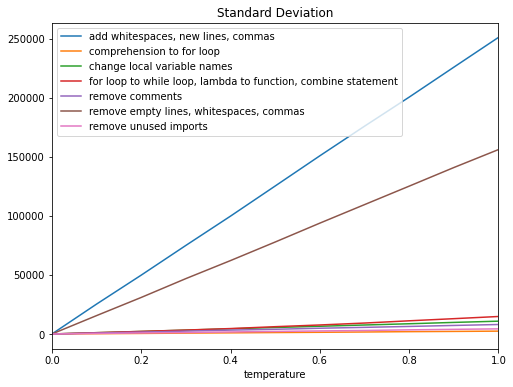

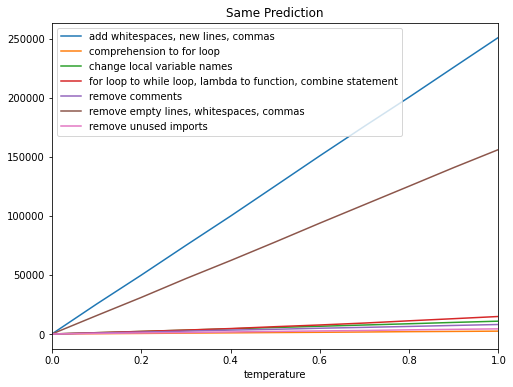

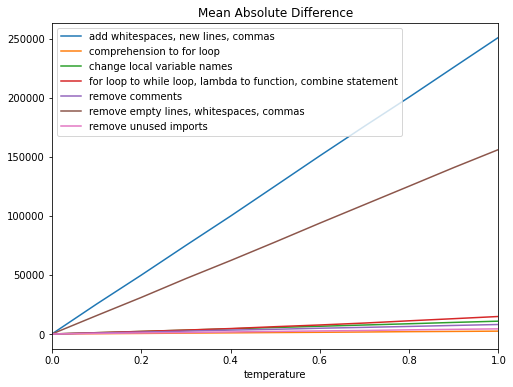

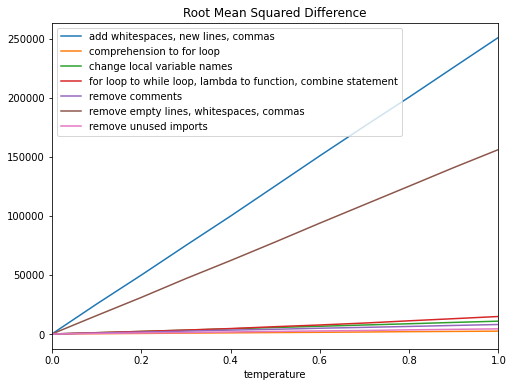

In [19]:
metrics_list = ['Accuracy', 'F1', 'Mean', 'Standard Deviation', 'Same Prediction', 'Mean Absolute Difference', 'Root Mean Squared Difference']
# cm = plt.get_cmap('gist_rainbow')

for metric in metrics_list:
    plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
    for i, transformation_type in enumerate(transformation_types):
        plt.plot(x, [sum(logs[transformation_type][p].values()) for p in targets], label=labels[transformation_type])

    plt.title(metric)
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
    plt.show()

# Print results

In [20]:

for p in targets:
    print(f'======================== [p = {p}] ================================')
    for key in logs.keys():
        print(logs[key][p])
        print(sum(logs[key][p].values()))
        print(results[key][p])
        print()

======================== [p = 0.0] ================================
Counter()
0
{'Accuracy': 0.8482000231742859, 'F1': 0.8629221600144483, 'Mean': 1.5386816241636299, 'Standard Deviation': 1.88646069390785, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8482000231742859, 'F1': 0.8629221600144483, 'Mean': 1.5386816241636299, 'Standard Deviation': 1.88646069390785, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8482000231742859, 'F1': 0.8629221600144483, 'Mean': 1.5386816241636299, 'Standard Deviation': 1.88646069390785, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8482000231742859, 'F1': 0.8629221600144483, 'Mean': 1.5386816241636299, 'Standard Deviation': 1.88646069390785, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.8482000231742859, 'F1': 0.8629221600144483, 'Mean': 1.5386816241636299, 'Standard Deviation': 1.88646069390785, 'Same

# Print cases when the predictions are changed

In [21]:


def print_code_diff(text, code1, code2, similar, show_diff=False, show_codes=True):
    print('==================================================================')
    print(text)
    print('------------------------------------------------------------------')
    if show_diff:
        print(
            "".join(
                difflib.unified_diff(code1.splitlines(1), code2.splitlines(1))
            )
        )
        print('------------------------------------------------------------------')
    if show_codes:
        print(code1)
        print('------------------------------------------------------------------')
        print(code2)
    print('------------------------------------------------------------------')
    print(f'similar (original): {similar}')
    print('==================================================================')
    
for p in targets[1:]:
    print(f'############################## [p = {p}] #####################################')
    for key in diffs.keys():
        print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
        item = diffs[key][p]
        size = len(diffs[key][p])
        for i in range(min(3, size)):
            original = data[item[i]]['original']['code1']
            augmented = data[item[i]]['augmented'][p2index[p]]['code1'][key]
            similar = data[item[i]]['original']['similar']
            print_code_diff(f"p={p}, key={key}", original, augmented, similar, show_diff=True)
            print('====================================================================')
            time.sleep(0.5)
    

############################## [p = 0.1] #####################################
%%%%%%%%%%%%%%%%%%%%%% [key = add_whitespace,add_new_lines,add_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.1, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -3,7 +3,7 @@
 #最大公約数
 def gcd(x, y):
     while y:
-        x, y = y, x % y
+        x, y = y, x % y,
     return x
 
 #最小公倍数

------------------------------------------------------------------
A, B = map(int, input().split())

#最大公約数
def gcd(x, y):
    while y:
        x, y = y, x % y
    return x

#最小公倍数
def lcm(x, y):
    return x * y // gcd(x, y)

print(lcm(A, B))

------------------------------------------------------------------
A, B = map(int, input().split())

#最大公約数
def gcd(x, y):
    while y:
        x, y = y, x % y,
    return x

#最小公倍数
def lcm(x, y):
    return x * y // gcd(x, y)

print(lcm(A, B))

------------------------------------------------------------------
simila

# Print for "remove_empty_line,remove_whitespace,remove_commas"

In [22]:
key = "remove_empty_line,remove_whitespace,remove_commas"
for p in targets[1:]:
    print(f'############################## [p = {p}] #####################################')
    for item in random.sample(data, 5):
        original = item['original']['code1']
        augmented = item['augmented'][p2index[p]]['code1'][key]
        similar = item['original']['similar']
        print(item['augmented'][p2index[p]]['code1_log'][key])
        print_code_diff(f"p={p}, key={key}", original, augmented, similar, show_diff=True)
        print('====================================================================')
        time.sleep(0.5)

############################## [p = 0.1] #####################################
{'remove_empty_line': 1, 'remove_whitespace': 0, 'remove_commas': 0}
p=0.1, key=remove_empty_line,remove_whitespace,remove_commas
------------------------------------------------------------------

------------------------------------------------------------------
a,b=map(int,input().split())

print((a//b)+1 if a%b!=0 else a//b)
------------------------------------------------------------------
a,b=map(int,input().split())

print((a//b)+1 if a%b!=0 else a//b)
------------------------------------------------------------------
similar (original): 1
{'remove_empty_line': 0, 'remove_whitespace': 0, 'remove_commas': 0}
p=0.1, key=remove_empty_line,remove_whitespace,remove_commas
------------------------------------------------------------------

------------------------------------------------------------------
def f(input1):
  if input1 >= 30:
    return 'Yes'
  return 'No'

if __name__ == "__main__":
  input1 =

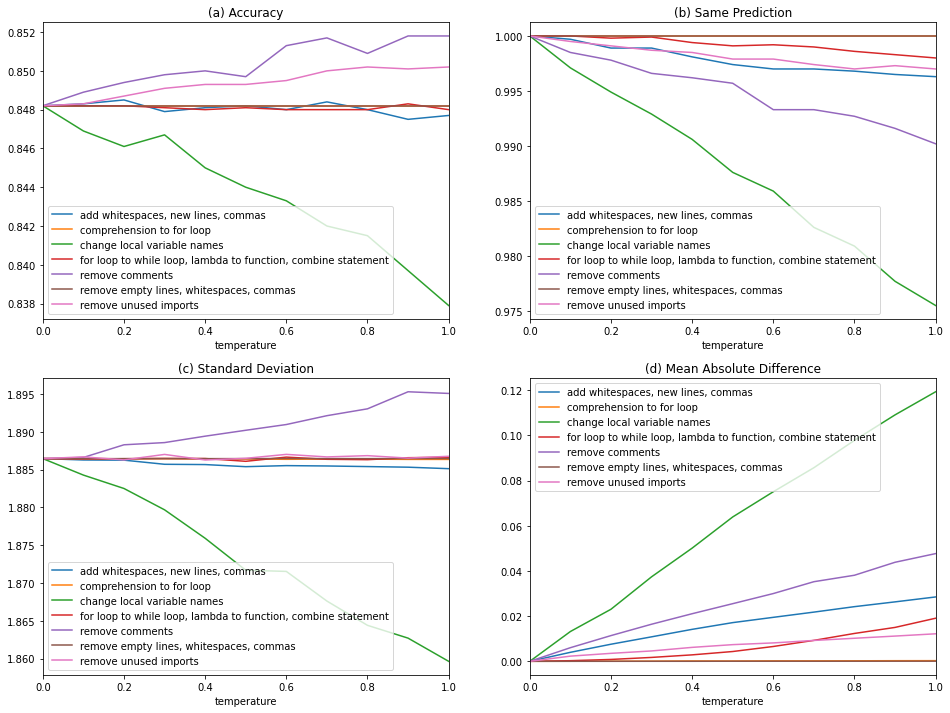

In [23]:

import string
plt.figure(figsize=(16, 12))
for i, metric in enumerate(['Accuracy', 'Same Prediction', 'Standard Deviation', 'Mean Absolute Difference']):
    plt.subplot(2,2,i+1)
#     ax = fig.add_subplot(111)
    for j, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])

    plt.title(f"({string.ascii_lowercase[i]}) {metric}")
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
plt.savefig('0411')